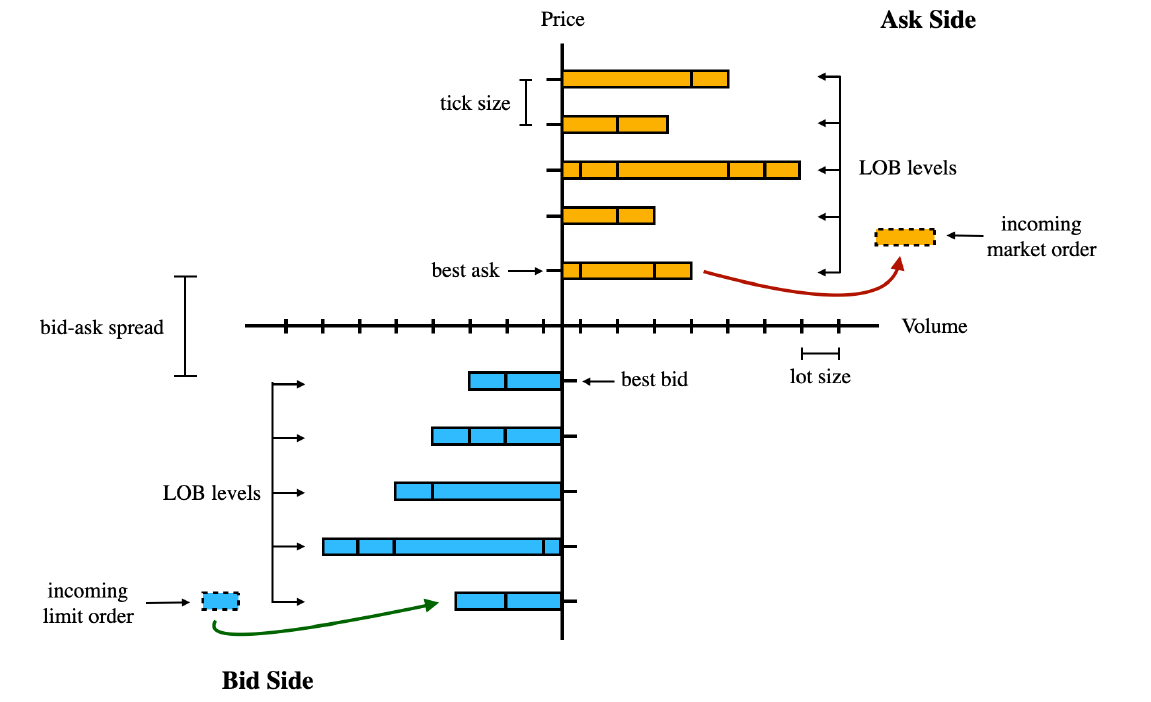

- 1. Go to https://lobsterdata.com/info/DataSamples.php and download the 10 level data for amazon and microsoft
- 2. Save in a folder named 'data' where this file is saved.


Data & Book: You can download the book "Trades, Quotes and Prices" by logging into Cambridge Univ. Press with your UCL credentials.
https://www.cambridge.org/core/books/trades-quotes-and-prices/029A71078EE4C41C0D5D4574211AB1B5
In the preface you can find the password to download a snapshot of the LOB for free: https://lobsterdata.com/
You can also access sample data of single stocks https://lobsterdata.com/info/DataSamples.php
Other data sources: https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed [1 level LOB data]

Other data (crypto): https://github.com/ccxt 


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import numpy as np
from matplotlib.dates import DateFormatter
import os 
  
cwd=os.getcwd()

#The time component in the data is recorded in seconds after midnight.

startTrad = 9.5*60*60       # 9:30:00.000 in s after midnight
endTrad = 16*60*60        # 16:00:00.000 in s after midnight

# Message file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x 6)

  - Structure:    Each row:
                  Time stamp (sec after midnight with decimal
                  precision of at least milliseconds and
                  up to nanoseconds depending on the period),
                  Event type, Order ID, Size (# of shares),
                  Price, Direction

                  Event types:
                      - '1'   Submission new limit order
                      - '2'   Cancellation (partial)
                      - '3'   Deletion (total order)
                      - '4'   Execution of a visible limit order
                      - '5'   Execution of a hidden limit order
			- '7'   Trading Halt (Detailed 
                              information below)

                  Direction:
                      - '-1'  Sell limit order
                      - '1'  Buy limit order
                      - NOTE: Execution of a sell (buy)
                              limit order corresponds to
                              a buyer-(seller-) initiated
                              trade, i.e. a BUY (SELL) trade.

----------------------------------------------------------

This loads the data using Pandas. It filters for messages sent between 0930 and 1600.

In [2]:
def load_data(ticker='AMZN',time_format=False,startTrad=startTrad,endTrad=endTrad):

    theMessageBookFileName = ticker+"_2012-06-21_34200000_57600000_message_10.csv"  #change this if you load other samples
    theMessageBookFileName=os.path.join(cwd,"data",theMessageBookFileName) #specify data location (in this case inside 'data' folder)


    theMessageBook = pd.read_csv(theMessageBookFileName, names = ['Time','Type','OrderID','Size','Price','TradeDirection'])

    #we will need this for filtering the orderbook data#
    theMessageBook['row_index']=theMessageBook.index.values

    theMessageBookFiltered = theMessageBook[theMessageBook['Time'] >= startTrad] 
    theMessageBookFiltered = theMessageBookFiltered[theMessageBookFiltered['Time'] <= endTrad]
    
    if time_format:
        theMessageBookFiltered=theMessageBookFiltered.set_index(pd.to_datetime(theMessageBookFiltered.Time,unit='s'))
    
    return theMessageBookFiltered

In [3]:
msg_book_amzn=load_data(ticker='AMZN',time_format=True)
msg_book_msft=load_data(ticker='MSFT',time_format=True)

In [4]:
# Q1: Check this has done what we think it should do. 
#Let's print the first rows and last rows of the dataframe.
msg_book_amzn.head()
msg_book_amzn.tail()

,Time,Type,OrderID,Size,Price,TradeDirection,row_index
Time,,,,,,,
1970-01-01 15:59:59.872741285,57599.872741,3,286560364,100,2207600,-1,269743
1970-01-01 15:59:59.903989046,57599.903989,3,287142900,100,2206200,-1,269744
1970-01-01 15:59:59.955241980,57599.955242,3,286967592,170,2206900,-1,269745
1970-01-01 15:59:59.958244616,57599.958245,1,287174077,100,2206300,-1,269746
1970-01-01 15:59:59.959359650,57599.959360,3,287174077,100,2206300,-1,269747


In [5]:
# Q2: How many events in this trading day for the two stocks?
print(msg_book_amzn.Size.sum())
print(msg_book_msft.Size.sum())

26130625
347108132


In [6]:
# Q3: up to which temporal precision do we get the data? (minute/seconds,etc.)
msg_book_msft.index.dtype

dtype('<M8[ns]')

What is the distribution of events?

In [7]:
# Q4: create a 'summary' function that aggregates events by type (cancellations, hidden/visible etc.) 
# and (1) counts them and (2) calculate the share of volume traded. Any observation?

In [8]:
#   - '1'   Submission new limit order
#   - '2'   Cancellation (partial)
#   - '3'   Deletion (total order)
#   - '4'   Execution of a visible limit order
#   - '5'   Execution of a hidden limit order
def summary(msg_book):
    summary=msg_book.groupby('Type')['Size'].agg(['count','sum'])
    summary=summary/summary.sum()
    summary['description']=summary.index.map({1:'New LO',2:'Cancel',3:'Deletion',4:'Execution visible',5:'Execution hidden'})
    return summary

In [9]:
#Q3: What does this function calculate?
# Count and sum of five types of orders, normalised by dividing V_D daily trading volume.

#Q4: Print a summary of all the events for the two stocks AMZ & MSFT
print(summary(msg_book_amzn))
print(summary(msg_book_msft))

#Q5: Which observations can we make about the occurrence of the different events?


         count       sum        description
Type                                       
1     0.489175  0.498550             New LO
2     0.010814  0.013223             Cancel
3     0.457679  0.457200           Deletion
4     0.033268  0.023469  Execution visible
5     0.009064  0.007558   Execution hidden
         count       sum        description
Type                                       
1     0.492798  0.503541             New LO
2     0.008377  0.006280             Cancel
3     0.448862  0.458995           Deletion
4     0.044557  0.028486  Execution visible
5     0.005407  0.002699   Execution hidden


Check for trading halts.

----------------------------------------------------------
When trading halts, a message of type '7' is written into the 
'message' file. The corresponding price and trade direction 
are set to '-1' and all other properties are set to '0'. 

Should the resume of quoting be indicated by an additional 
message in NASDAQ's Historical TotalView-ITCH files, another 
message of type '7' with price '0' is added to the 'message' 
file. Again, the trade direction is set to '-1' and all other 
fields are set to '0'.

When trading resumes a message of type '7' and 
price '1' (Trade direction '-1' and all other 
entries '0') is written to the 'message' file. 

For messages 
of type '7', the corresponding order book rows contain a 
duplication of the preceding order book state. The reason 
for the trading halt is not included in the output.

Example: Stylized trading halt messages in 'message' file.				

Halt: 			36023	| 7 | 0 | 0 | -1 | -1
                                    ...
Quoting: 		36323 	| 7 | 0 | 0 | 0  | -1
                                    ...
Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
                                    ...
The vertical bars indicate the different columns in the message file.


Check on Nasdaq historical trading halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHalts# and reason for halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHaltCodes

NYSE https://www.nyse.com/trade-halt-current

In [10]:
def check_for_halts(theMessageBookFiltered):

    # Note: As the rows of the message and orderbook file correspond to each other, the time index of
    # the message file can also be used to 'cut' the orderbook file.

    # Check for trading halts
    # ----------------------------------------------------------
    tradingHaltIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == -1) & (theMessageBookFiltered.TradeDirection == -1)]

    tradeQuoteIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 0)& (theMessageBookFiltered.TradeDirection == -1)]

    tradeResumeIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 1)& (theMessageBookFiltered.TradeDirection == -1)]

    if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
        print("No trading halts detected.")

    if(len(tradingHaltIdx) != 0):
        print("Data contains trading halt! at timestamp(s): "); print(list(tradingHaltIdx))

    if(len(tradeQuoteIdx) != 0):
        print(" Data contains quoting message! at timestamp(s)"); print(list(tradeQuoteIdx)) 

    if(len(tradeResumeIdx) != 0):
        print(" Data resumes trading! at timestamp(s) "); print(list(tradeResumeIdx))

In [11]:
#Q6: Chech whether any trading halt is recorded.
check_for_halts(msg_book_amzn)
check_for_halts(msg_book_msft)

No trading halts detected.
No trading halts detected.


# Plot - Number of Executions and Trade Volume by Interval
_____________________________________________________________________________
              
Note: Difference between trades and executions

   The LOBSTER output records limit order executions
   and not what one might intuitively consider trades (market orders).

   Imagine a volume of 1000 is posted at the best ask
   price. Further, an incoming market buy order of
   volume 1000 is executed against the quote.

   The LOBSTER output of this trade depends on the
   composition of the volume at the best ask price.
   Take the following two scenarios with the best ask
 	 volume consisting of ...
   	(a) 1 sell limit order with volume 1000
   	(b) 5 sell limit orders with volume 200 each
      	(ordered according to time of submission)

    The LOBSTER output for case ...
      (a) shows one execution of volume 1000. If the
          incoming market order is matched with one
          standing limit order, execution and trade
          coincide.
      (b) shows 5 executions of volume 200 each with the
          same timestamp. The incoming order is matched
          with 5 standing limit orders and triggers 5
          executions.
          
  --> When the data does not contain errors, these events occur at the same time t (same side of the LOB): by grouping them all together one can reconstruct the volume of the incoming market order. In general though, HF data contains errors and reconstructing MOs from raw data is non-trivial.

  Bottom line:
      LOBSTER records the exact limit orders against
      which incoming market orders are executed. Trade size has to be
      inferred from the executions.
     

In [12]:
#Q7 Generate a plot showing the number and size of visible and invisible executions for the two stocks


In [13]:
def visible_invisible_plot(df_in,ticker,rolling_seconds=300):
    #to resample we need to set index to a time index
    try:
        assert type(df_in.index) == pd.core.indexes.datetimes.DatetimeIndex
        
    except AssertionError:
        df = df_in.set_index(pd.to_datetime(df_in.Time, unit='s'))
    df = pd.DataFrame(df_in)

    #only select the trade executions (type 4 & 5)
    df = df[df.Type.isin([4, 5])]

    #separate out the data of interest into separate columns for size and number of executions, use fact that true =1 and  false=0
    df["Visible"] = (df.Type == 4)
    df["Visible_Size"] = df["Visible"] * df["Size"]

    df["Invisible"] = (df.Type == 5) * -1 # Times -1 for better plotting
    df["Invisible_Size"] = df["Invisible"] * df["Size"]

    #resample data into 5 minute intervals, sum contents of each time bucket.
    df_resampled = df.resample(str(rolling_seconds) + "S", label = "right").sum()

    # Plotting
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 6))

    ax[0].set_title(f'Invisible visible executions for {ticker} over {str(rolling_seconds)} sec rolling period')

    df_resampled[["Visible", "Invisible"]].plot(ax = ax[0], color = ["red", "blue"], kind = "area")
    ax[0].set_ylabel("Number of Executions")

    df_resampled[["Visible_Size", "Invisible_Size"]].plot(ax = ax[1], color = ["red", "blue"], kind = "area")
    ax[1].set_ylabel("Volume of Executions")

    plt.show()

    return df_resampled
    

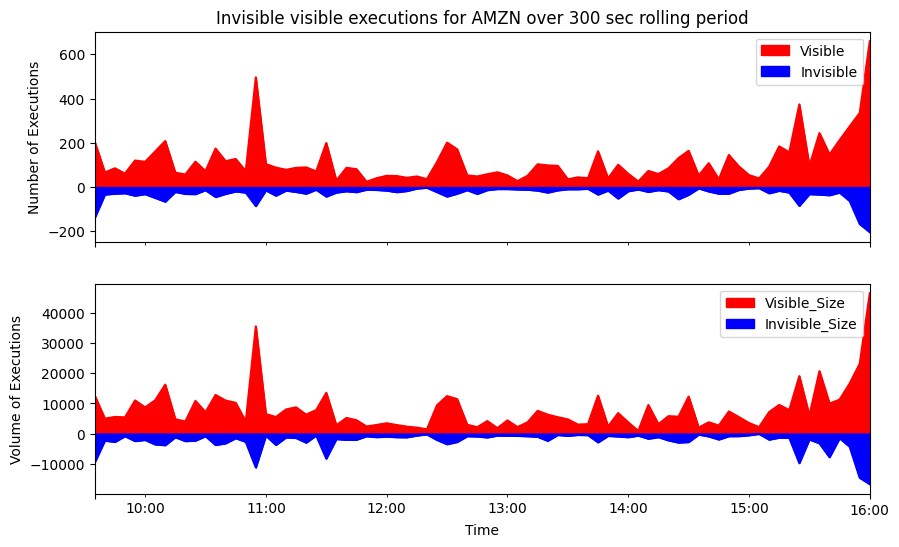

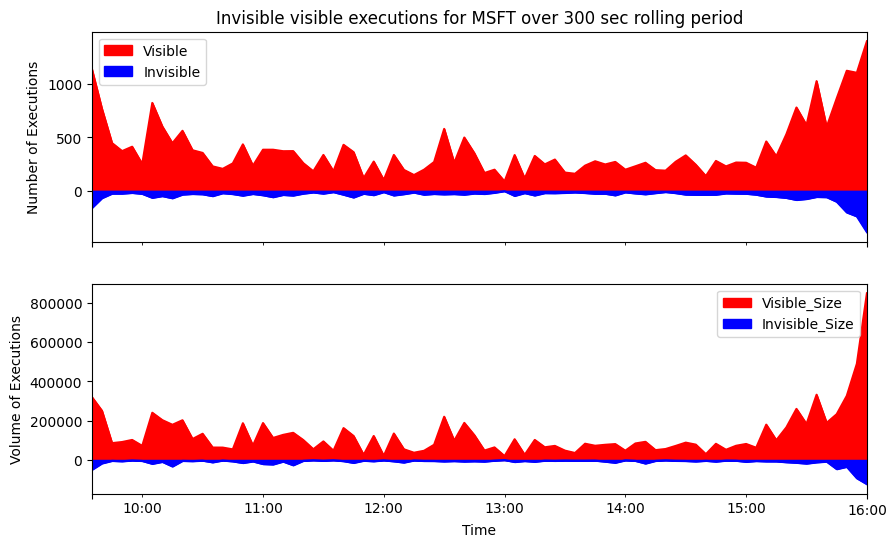

In [14]:
rsd_amzn = visible_invisible_plot(msg_book_amzn, "AMZN")
rsd_msft = visible_invisible_plot(msg_book_msft, "MSFT")

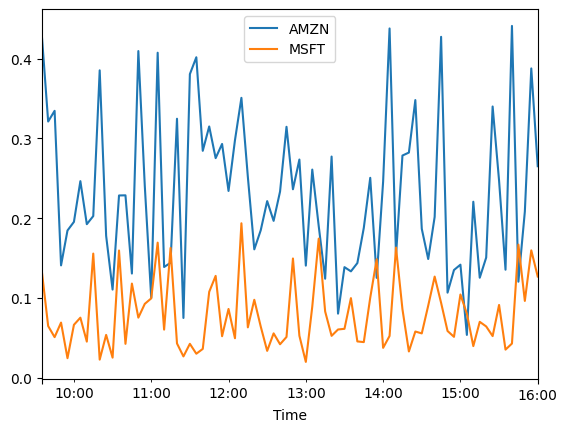

In [15]:
ax = (abs(rsd_amzn["Invisible_Size"]) / rsd_amzn["Size"]).plot(label = "AMZN")
(abs(rsd_msft["Invisible_Size"]) / rsd_msft["Size"]).plot(ax = ax, label = "MSFT")
plt.legend()
plt.show()

Now we are going to look at the order book data.

# Orderbook file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x (NumberLevels*4))

  - Structure:    Each row:
                  Ask price 1, Ask volume 1, Bid price 1,
                  Bid volume 1, Ask price 2, Ask volume 2,
                  Bid price 2, Bid volume 2, ...

  - Note:         Unoccupied bid (ask) price levels are
                  set to -9999999999 (9999999999) with volume 0.
				      
----------------------------------------------------------

In [16]:
def loadOrderBook(theMessageBook,ticker='AMZN'):
    #_____________________________________________________________________________
    #
    # Load Order Book File
    # This is going to output a dictionary of four dataframes - asks/bids prices/sizes
    #It will be indexed by the time index formed from the messagebook df
    #_____________________________________________________________________________
    nlevels = 10 #change number of levels

    # Load data
    theOrderBookFileName = ticker+"_2012-06-21_34200000_57600000_orderbook_10.csv"
    theOrderBookFileName=os.path.join(cwd,"data",theOrderBookFileName)
    print(theOrderBookFileName)

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']
    theNames=[str(col_name)+str(level_no)  for level_no in range(1,nlevels+1) for col_name in col ]

    theOrderBook = pd.read_csv(theOrderBookFileName, names = theNames)
        
    #timeIndex = theMessageBook.index[(theMessageBook.Time >= startTrad) & (theMessageBook.Time <= endTrad)]
    #theOrderBookFiltered = theOrderBook[theOrderBook.index == timeIndex]
        
    theOrderBookFiltered = theOrderBook.iloc[theMessageBook.row_index]
    
    #theOrderBookFiltered=theOrderBookFiltered.set_index(pd.to_datetime(theMessageBook.Time,unit='s'))
    theOrderBookFiltered=theOrderBookFiltered.set_index(theMessageBook.index)
    
    # Convert prices into dollars
    #    Note: LOBSTER stores prices in dollar price times 10000

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

    #separate the four types of column into a dictionary with key=column type
    data_col_dic={c.strip():[c+str(level_no)  for level_no in range(1,nlevels+1)] for c in col}

    #separate data into four aligned dataframes of the four different types of data with key=data type
    data_dic={c:theOrderBookFiltered[cols] for c,cols in data_col_dic.items()}
      
    return data_dic

In [17]:
OB_dic_amzn=loadOrderBook(msg_book_amzn,ticker='AMZN')
OB_dic_msft=loadOrderBook(msg_book_msft,ticker='MSFT')

c:\Users\Jason\OneDrive - University College London\MSc Computational Finance\Repositories\MSc-Computational-Finance\COMP0049\data\AMZN_2012-06-21_34200000_57600000_orderbook_10.csv
c:\Users\Jason\OneDrive - University College London\MSc Computational Finance\Repositories\MSc-Computational-Finance\COMP0049\data\MSFT_2012-06-21_34200000_57600000_orderbook_10.csv


The output is a dictionary of dataframes. Each row of this dataset should refer to the orderbook state after a new event has happened. So it should be the same length. Let us check that.

In [18]:
def data_checker(OB_dic,msg_book):

    for k,val in OB_dic.items():
        
        assert val.shape[0]==msg_book.shape[0]
        
        print("ok!",k,type(val),val.shape)
    
data_checker(OB_dic_amzn,msg_book_amzn)
data_checker(OB_dic_msft,msg_book_msft)

ok! Ask Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (668765, 10)


In [19]:
#Q6: check the structure of the data
OB_dic_amzn
#Q7: Compute bid, ask , mid-price, spread associated with each event.
ask_amzn = OB_dic_amzn["Ask Price"]
bid_amzn = OB_dic_amzn["Bid Price"]
spread_amzn = ask_amzn - bid_amzn

ask_msft = OB_dic_msft["Ask Price"]
bid_msft = OB_dic_msft["Bid Price"]
spread_msft = ask_msft - bid_msft

In [20]:
def order_book_look(OB_dic,ticker,random_no=None):
    # Note: Pick a random row/event from the order book if not specified
    
    if random_no is None:
        random_no = OB_dic['Bid Size'].sample().index[0]
    else:
        #first appearing event after the given time
        random_no=OB_dic['Bid Size'][OB_dic['Bid Size'].index>random_no].index[0]
      
    time=random_no.strftime('%H:%M:%S:%f')

    #
    # Plot 1 - Snapshot of the Limit Order Book
    #_____________________________________________________________________________

    fig,ax=plt.subplots(2,1,figsize=(9,9)) 

    bid_data=OB_dic['Bid Size'].loc[random_no]
    bid_prices=OB_dic['Bid Price'].loc[random_no]

    ask_data=OB_dic['Ask Size'].loc[random_no]
    ask_prices=OB_dic['Ask Price'].loc[random_no]


    ax[0].bar(ask_prices/10000,ask_data,
           width=0.007, color='#fc1b04', label='Ask')   # Divide price by 10000 to get price in dollars
    ax[0].bar(bid_prices/10000,bid_data,
           width=0.007,color='#13fc04', label='Bid')

    ax[0].set_ylabel('Quantity')
    ax[0].set_xlabel('Price($)')
    ax[0].set_title(f'Order book at {str(time)} for {ticker}')
    
    #Q8: add plot of DEPTH PROFILE
    levels = range(1, 11)
    ask_profile = np.cumsum(ask_data) / np.sum(ask_data)
    bid_profile = np.cumsum(bid_data) / np.sum(bid_data)
    ask_profile *= -1 # Move ask to negative side for better apperance

    # Two methods are equally good for creating step-wise plots
    ax[1].plot(levels, ask_profile, drawstyle='steps-post', color = '#fc1b04', label='Ask')
    ax[1].step(levels, bid_profile, color = '#13fc04', label='Bid')

    ax[1].set_xlabel(r"Levels")
    ax[1].set_ylabel(r"% Orderbook")
    ax[1].set_xlim([1, 10])
    ax[1].set_ylim([-1, 1])
    
    return random_no

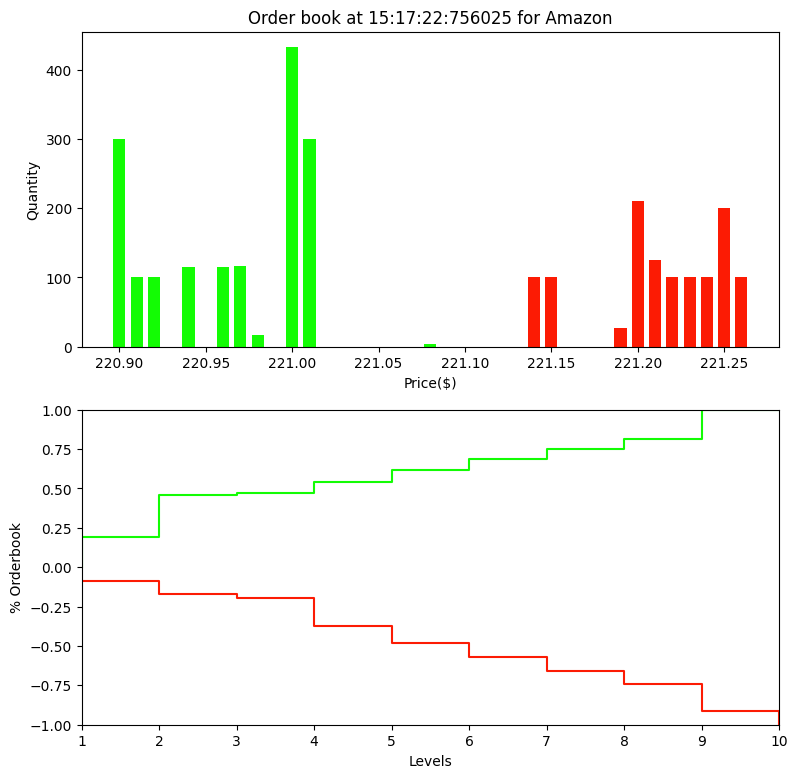

In [21]:
time=order_book_look(OB_dic_amzn,'Amazon')

Timestamp('1970-01-01 15:17:23.037961857')

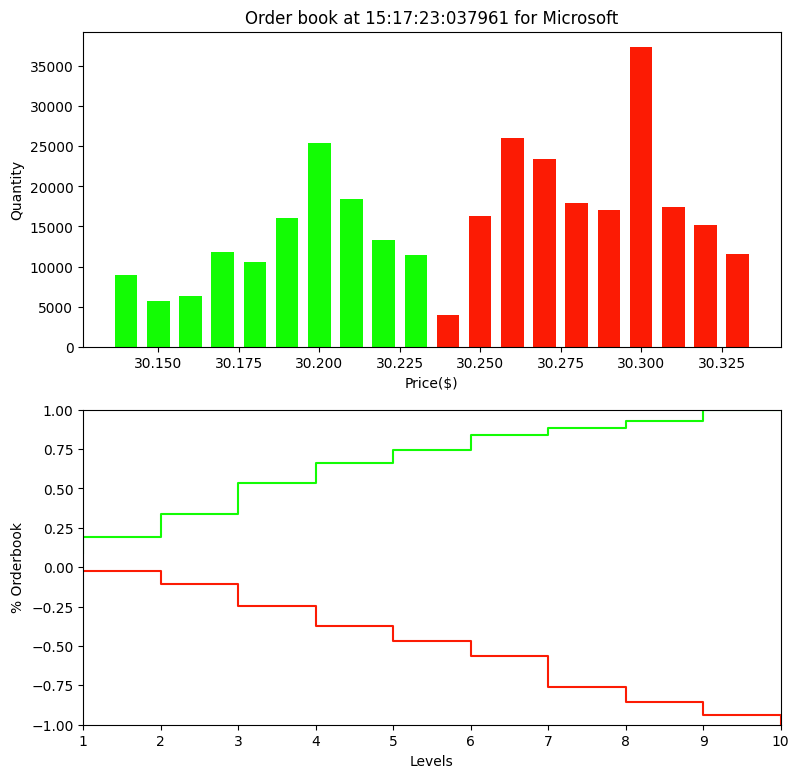

In [22]:
order_book_look(OB_dic_msft,'Microsoft',time)

# Event time vs time time

Event time is expressed as the sequence of events that occur in the limit order book. Sometimes it is convenient to think about of this as time instead of 'normal time'. 

In [23]:
msg_book_amzn.resample("1S").count()["Time"].rolling(300).mean()

Time
1970-01-01 09:30:00          NaN
1970-01-01 09:30:01          NaN
1970-01-01 09:30:02          NaN
1970-01-01 09:30:03          NaN
1970-01-01 09:30:04          NaN
                         ...    
1970-01-01 15:59:55    24.660000
1970-01-01 15:59:56    24.480000
1970-01-01 15:59:57    24.446667
1970-01-01 15:59:58    24.430000
1970-01-01 15:59:59    24.506667
Freq: S, Name: Time, Length: 23400, dtype: float64

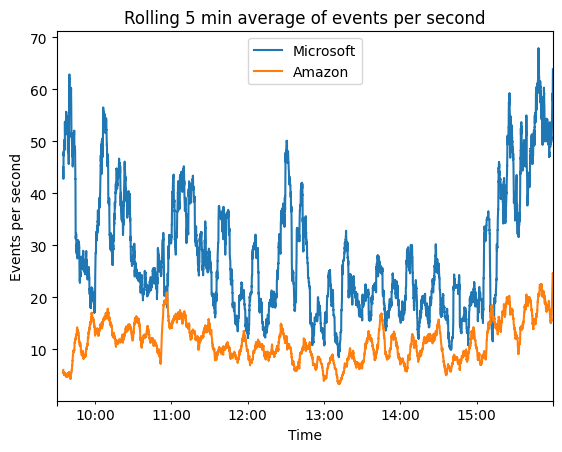

In [24]:

ax=msg_book_msft.resample("1S").count()['Time'].rolling(300).mean().plot(label='Microsoft',legend=True)
msg_book_amzn.resample("1S").count()['Time'].rolling(300).mean().plot(label='Amazon',legend=True,ax=ax,title='Rolling 5 min average of events per second')
_=ax.set_ylabel('Events per second')

In [25]:
#Q9:Rolling average of events (all types of events here) per second...try selecting only a sub-type (e.g. only executions)
msg_book_amzn.resample("1S").count()["Time"].rolling(300).mean()

Time
1970-01-01 09:30:00          NaN
1970-01-01 09:30:01          NaN
1970-01-01 09:30:02          NaN
1970-01-01 09:30:03          NaN
1970-01-01 09:30:04          NaN
                         ...    
1970-01-01 15:59:55    24.660000
1970-01-01 15:59:56    24.480000
1970-01-01 15:59:57    24.446667
1970-01-01 15:59:58    24.430000
1970-01-01 15:59:59    24.506667
Freq: S, Name: Time, Length: 23400, dtype: float64

# Empirical properties of the LOB - large and small tick stocks

Now we are going to look at how a large tick stock - Microsoft differs from a small tick stock - Amazon.

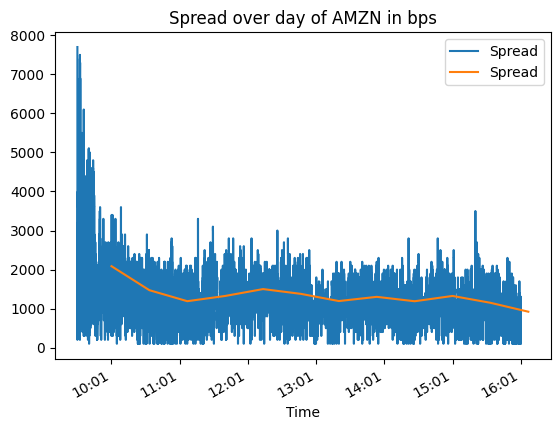

,Spread
Time,
1970-01-01 09:30:00.017459617,7700
1970-01-01 09:30:00.189607670,1400
1970-01-01 09:30:00.189607670,1400
1970-01-01 09:30:00.189607670,1400
1970-01-01 09:30:00.189607670,1400
...,...
1970-01-01 15:59:59.872741285,1100
1970-01-01 15:59:59.903989046,1300
1970-01-01 15:59:59.955241980,1300


In [26]:
#Q10 Plot the spread and its moving average(over a period of 300s).
#Q11 Plot the depth at best and its moving average(over a period of 300s).

def spread_plot(OB_dic, ticker, rolling_unit = 2000):
    spread = pd.DataFrame((OB_dic["Ask Price"]["Ask Price 1"] - OB_dic["Bid Price"]["Bid Price 1"]), columns = ["Spread"])
    spread_rolling = spread.resample(str(rolling_unit) + "S", label = "right").mean()

    ax = spread.plot()
    spread_rolling.plot(ax = ax, label = f"{rolling_unit}S mavg")
    ax.legend()
    ax.set_title(f"Spread over day of {ticker} in bps")

    # Formatting time to hours and minutes
    myFmt = DateFormatter("%H:%m")
    ax.xaxis.set_major_formatter(myFmt)

    plt.show()

    return spread

spread_plot(OB_dic_amzn, "AMZN")

# Event rates in the LOB

In [27]:
#get all of the LO submissions

def abs_dist(price,side,best_ask,best_bid):
    #little function to get absolute distance to best depending on order type
    if side==1:
        return best_bid-price
    elif side==-1:
        return price-best_ask



def event_rate(msg_book,OB_dic,Type=1):
    events=msg_book[msg_book.Type.isin([1])]
    
    #get the raw information we need from the Orderbook (Best bid and ask events)
    Best_state=pd.DataFrame({'Best_bid':OB_dic['Bid Price']['Bid Price 1'],
                             'Best_ask':OB_dic['Ask Price']['Ask Price 1']})
    
    #we want to know the state of the order book before submission of an order
    Best_state['prev_Best_bid']=Best_state.Best_bid.shift(1)
    Best_state['prev_Best_ask']=Best_state.Best_ask.shift(1)
    Best_state.fillna(0,inplace=True)

    #not necessary but this column return true if the best bid/ask has improved
    Best_state['Bid_improved']=Best_state['Best_bid']>Best_state['prev_Best_bid']
    Best_state['Ask_improved']=Best_state['Best_ask']<Best_state['prev_Best_ask']
    
    #merge the order book information with the message information    
        #events=events.merge(Best_state.iloc[events.row_index],left_on='row_index',right_on='row_index')
    #prefer concat because we know the rows are aligned. merge may get into trouble for simultaneous events.
    events=pd.concat([events,Best_state.iloc[events.row_index]],sort=False,axis=1)
    
    #apply absolute distance calculation row by row. 
    #This is slow way to do it but 
    events['abs_dist']=events.apply(lambda x: abs_dist(x['Price'],x['TradeDirection'],x['prev_Best_ask'],
                                                       x['prev_Best_bid']),axis=1 )
    
    
    
    return events


This is this the distribution of LO submissions wrt their absolute distance from best.

<Axes: >

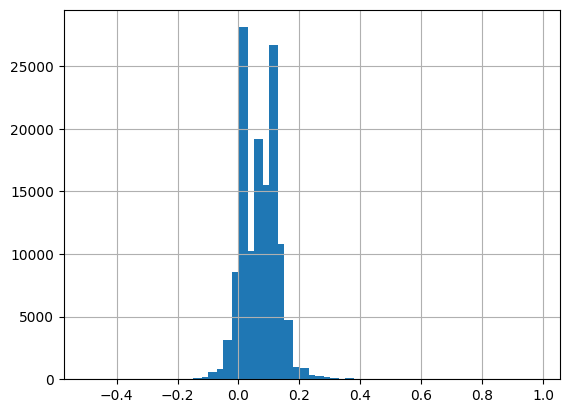

In [28]:
events_amzn=event_rate(msg_book_amzn,OB_dic_amzn,1)
(events_amzn['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

<Axes: >

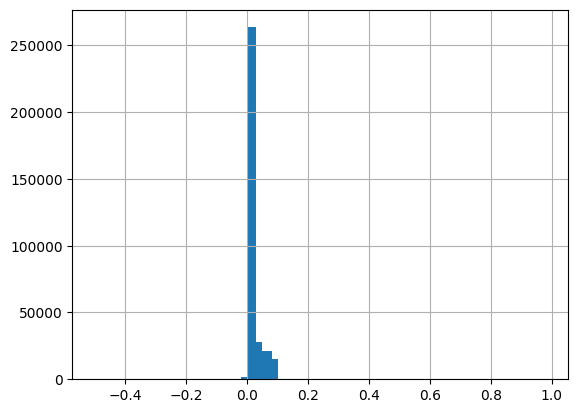

In [29]:
events_msft=event_rate(msg_book_msft,OB_dic_msft,1)
(events_msft['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

Note that there are LOs with negative absolute distance? These are best improving orders (bid above best or ask below)

In [30]:
bi=(events_msft.Bid_improved | events_msft.Ask_improved).value_counts()
bi/bi.sum()

False    0.993843
True     0.006157
Name: count, dtype: float64

In [31]:
bi=events_amzn.Bid_improved.value_counts()
bi/bi.sum()

Bid_improved
False    0.949899
True     0.050101
Name: count, dtype: float64